In [1]:
# make Notebook wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("immo_data.csv")     

print("df shape:", df.shape)
display(df.info())
display(df.head())

./.gitignore
./immo_data.csv.zip
./immo_data.csv
./data_analysis.ipynb
./.ipynb_checkpoints/data_analysis-checkpoint.ipynb
df shape: (268850, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstr

None

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [2]:

import matplotlib.pyplot as plt

# pd.set_option('max_columns', None)

def plot_barh(dict, title=""):
    full_height = (len(dict.keys())) / 3
    plt.figure(figsize=(10, full_height))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.title(title)
    pp = plt.barh(list(dict.keys()), list(dict.values()), align='center', alpha=0.5)

    for p in pp:
       width = p.get_width()
       plt.annotate('{}'.format(width),
          xy=(width, p.get_y()),
          xytext=(3, 6),
          textcoords="offset points",
          ha='left', va='center')
    plt.show()

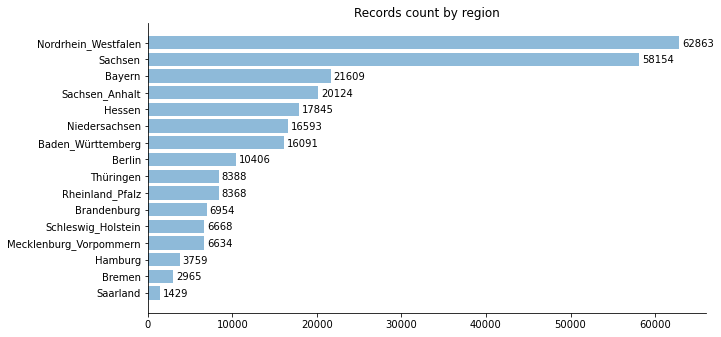

In [3]:
record_count_by_region = df.groupby(['regio1']).size().sort_values(ascending=True).to_dict()
plot_barh(record_count_by_region, "Records count by region")


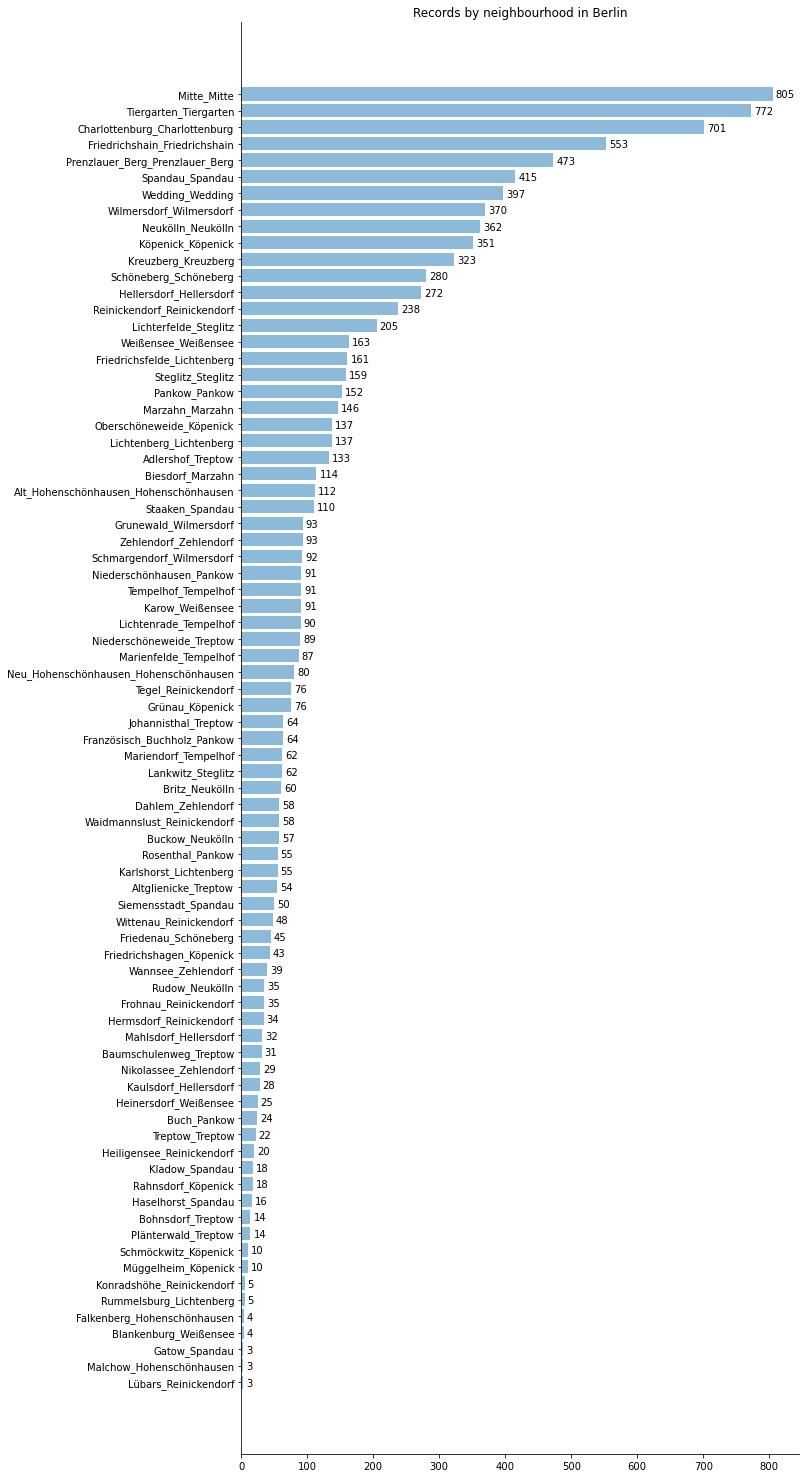

In [4]:

berlinDf = df[df['regio1']=='Berlin']
records_by_neighbourhood_in_berlin = berlinDf.groupby(['regio3']).size().sort_values(ascending=True).to_dict()
plot_barh(records_by_neighbourhood_in_berlin, "Records by neighbourhood in Berlin")


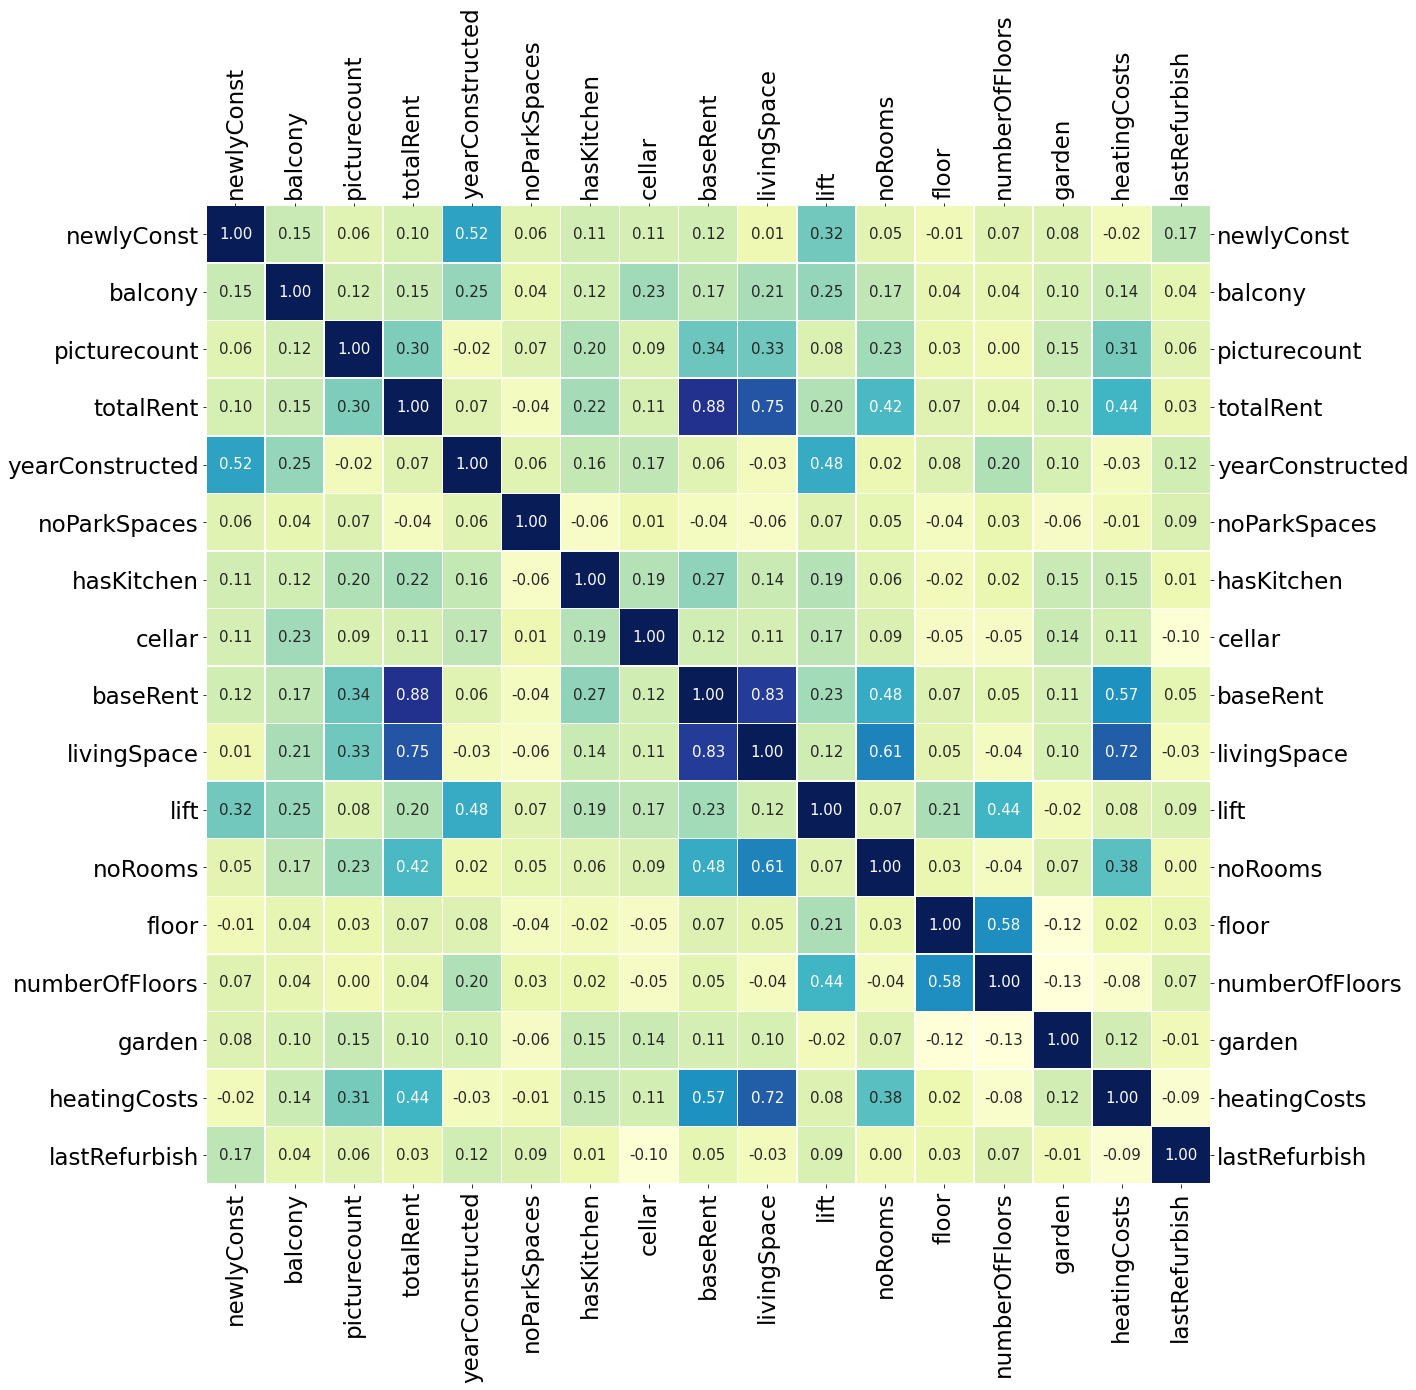

In [5]:
useful_columns = [
    'regio1', 'heatingType', 'newlyConst', 'balcony', 'picturecount', 'totalRent', 'yearConstructed', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'baseRent', 'livingSpace', 'condition', 'interiorQual', 'petsAllowed', 'lift', 'typeOfFlat', 'noRooms', 'floor', 'numberOfFloors', 'garden', 'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish', 
]
berlinDf_select = berlinDf[useful_columns]
correlation = berlinDf_select.corr()

import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
sn.heatmap(correlation, annot=True, cbar=False, linewidths=.5, cmap="YlGnBu", fmt='.2f', annot_kws={'size': 15})
plt.tick_params(axis='both', which='major', labelsize=23, labelbottom = True, bottom=True, top = True, labeltop=True, right=True, labelright=True)
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

plt.show()

# Checking the baseRent corelation with possible features:
# Data shows that livingSpace and noRooms has the highest corelation ~0.8. 
# But constucton year is important too ~0.5.
# Surprisingly seems like heatingCost is also directly corelated with baseRent too. I was expecting this to be inverse corelated.

# Result: We will experiement with following columns for training: livingSpace, noRooms, heatingCosts, hasKitchen, cellar, garden, balcony
#         Plus categorical columns for: heatingType, firingTypes, condition', 'interiorQual', 'petsAllowed, energyEfficiencyClass


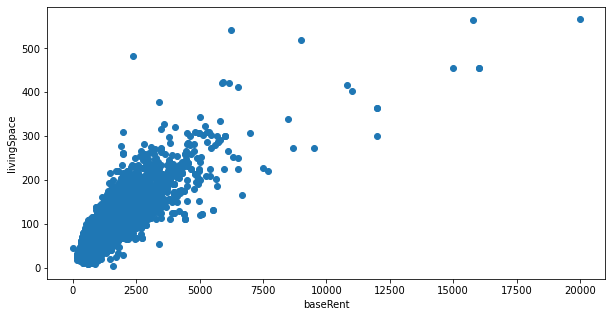

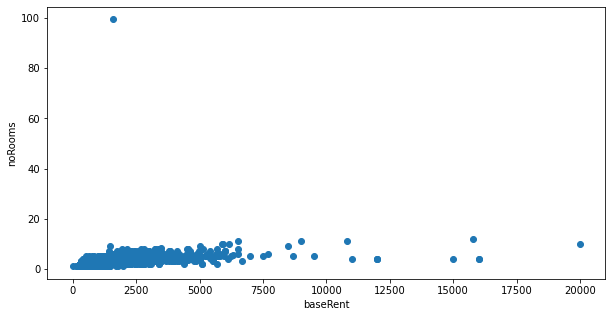

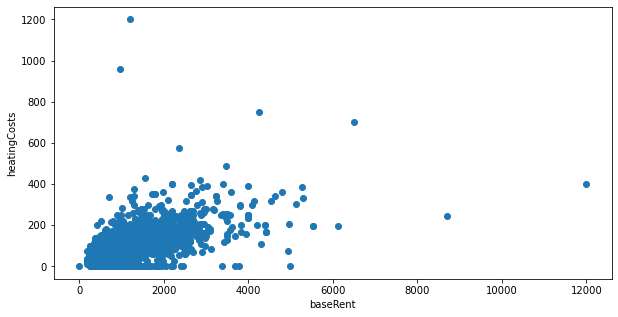

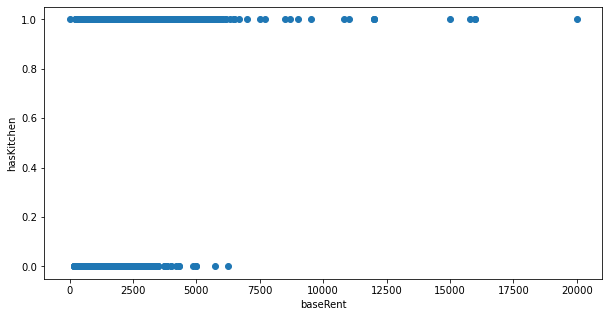

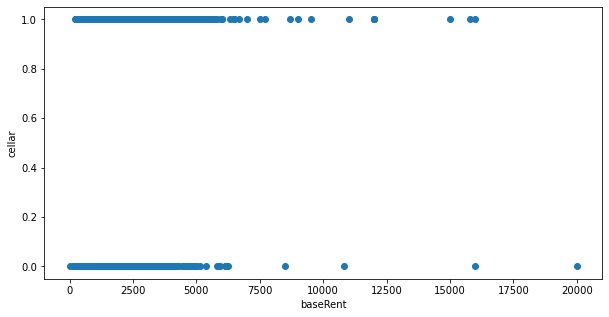

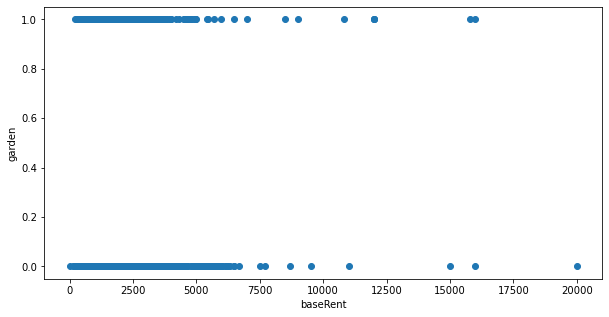

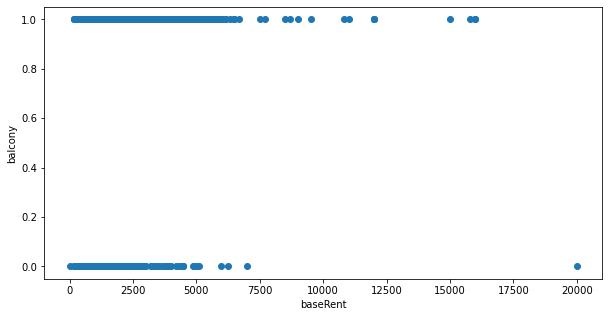

In [9]:
import matplotlib.pyplot as plt


def plot_ticks(x, y, x_label, y_label):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

for c in ["livingSpace", "noRooms", "heatingCosts", "hasKitchen", "cellar", "garden", "balcony"]:
    plot_ticks(berlinDf_select["baseRent"], berlinDf_select[c], 'baseRent', c)
    

<ipython-input-10-3ea56563edfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berlinDf_select[c] = berlinDf_select[c].fillna("NO_INFORMATION")


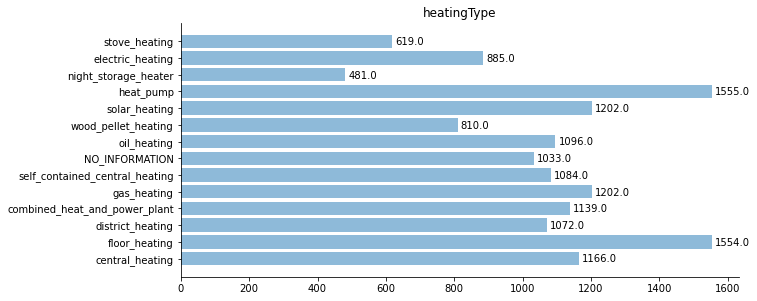

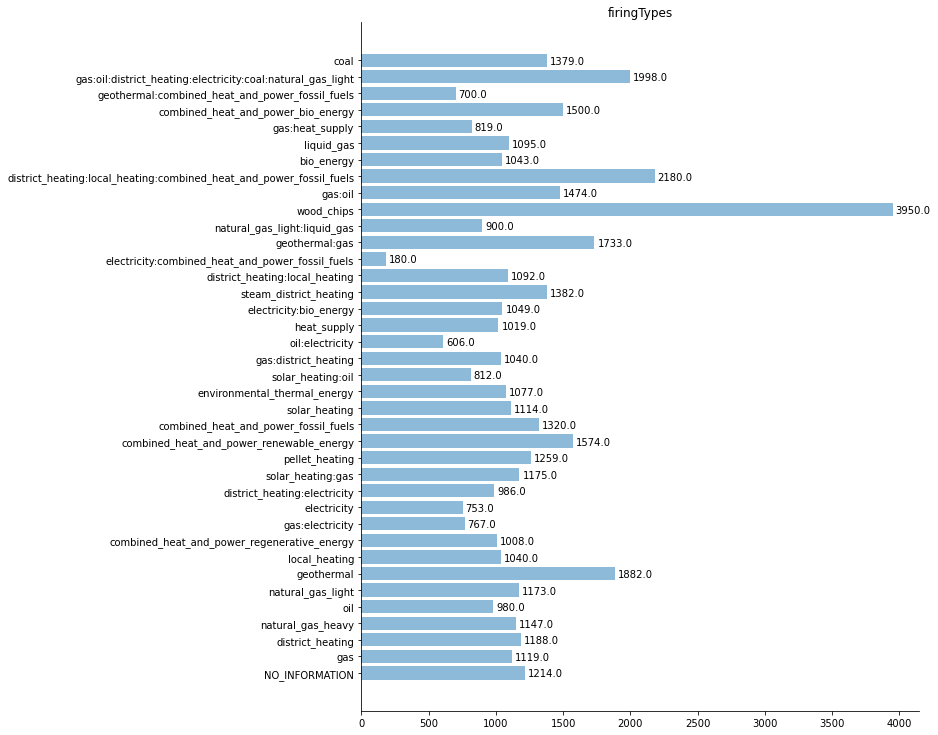

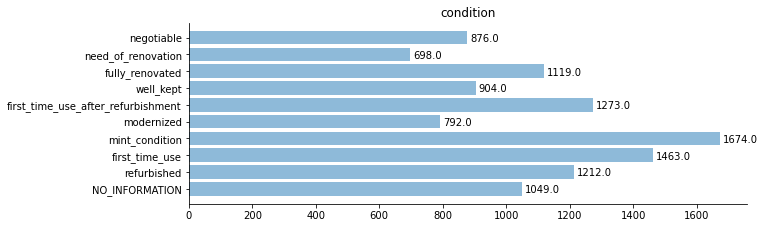

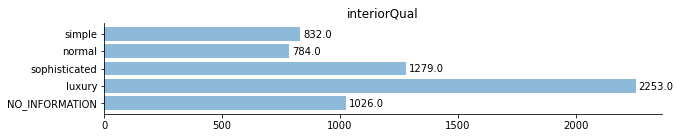

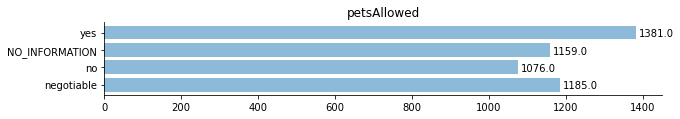

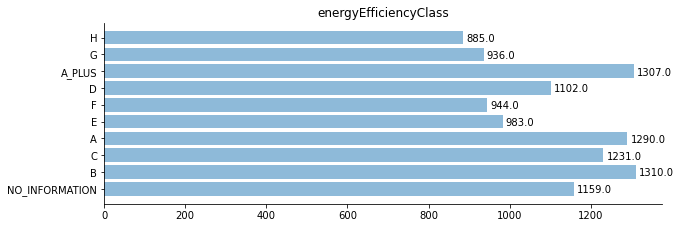

In [10]:
for c in ["heatingType", "firingTypes", "condition", "interiorQual", "petsAllowed", "energyEfficiencyClass"]:
    berlinDf_select[c] = berlinDf_select[c].fillna("NO_INFORMATION")
    classes = berlinDf_select[c].unique()
    data = {}
    for cl in classes:
        mean = berlinDf_select[berlinDf_select[c]==cl]["baseRent"].mean()
        data[str(cl)] = round(mean,0)
    plot_barh(data, c)


In [7]:
# We will experiment training by:
#     - exluding the ["hasKitchen", "cellar", "garden", "balcony"]
#     - excluding records with baseRent bigger than 5000 and 7500
#     - exclude record with noRooms > 10
#     - exclude records with heatingCosts > 500